# Initialization

In [858]:
import pandas as pd 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,ENGLISH_STOP_WORDS,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, f1_score, recall_score
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb 
import seaborn as sns

# Data import DJIA

In [859]:
apple = pd.read_csv(r'C:/Users/ADMIN/Documents/Codebase/Data-science-projects/Stock_from_sentiment/Data/AAPL.csv')
apple.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,News
0,12/1/2006,13.114285,13.190000,12.871428,91.320000,13.045714,198769900,WHAT'S ON TONIGHT : 8 P.M. (TLC) ASHLEY JUDD A...
1,12/4/2006,13.125714,13.150000,12.928572,91.120003,13.017143,177384200,More on Housing Prices : The broadest governme...
2,12/6/2006,12.948571,13.055715,12.810000,89.830002,12.832857,159546100,Honoring R.W. Apple in Words and Food : About ...
3,12/7/2006,12.861428,12.928572,12.414286,87.040001,12.434286,251206900,"Homebuilders, and Worries Over Jobs, Lead a De..."
4,12/8/2006,12.461429,12.770000,12.428572,88.259995,12.608571,196069300,"Homebuilders, and Worries Over Jobs, Lead a De..."


In [860]:
micro = pd.read_csv(r'C:/Users/ADMIN/Documents/Codebase/Data-science-projects/Stock_from_sentiment/Data/MSFT.csv')
micro.head(5)

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,News
0,1.0,12/4/2006,29.230000,29.520000,29.170000,29.330000,29.330000,55123400,The Retooling of a Search Engine : Ask.com is ...
1,NaN,12/6/2006,29.100000,29.129999,28.870001,28.990000,28.990000,48564100,Combat as Usual? Not With These Games : A few ...
2,3.0,12/7/2006,28.959999,29.070000,28.809999,28.850000,28.850000,46831100,Vista Is Ready. Are You? : Why it might be a b...
3,4.0,12/12/2006,29.559999,29.629999,29.219999,29.430000,29.430000,68529400,Take the Hotel Room Home : Hotels have become ...
4,NaN,12/13/2006,29.600000,29.600000,29.320000,29.549999,29.549999,46002500,Google to Offer Variation on Stock Options : G...


# Data exploration

In [861]:
apple.shape

(2323, 8)

In [862]:
sents=[]
apple_news=''
micro_news=''
sents=[sent for sent in apple.News]
for j in range(len(sents)):
    apple_news=apple_news+str(sents[j])
sents=[]
sents=[sent for sent in micro.News]
for j in range(len(sents)):
    micro_news=micro_news+str(sents[j])


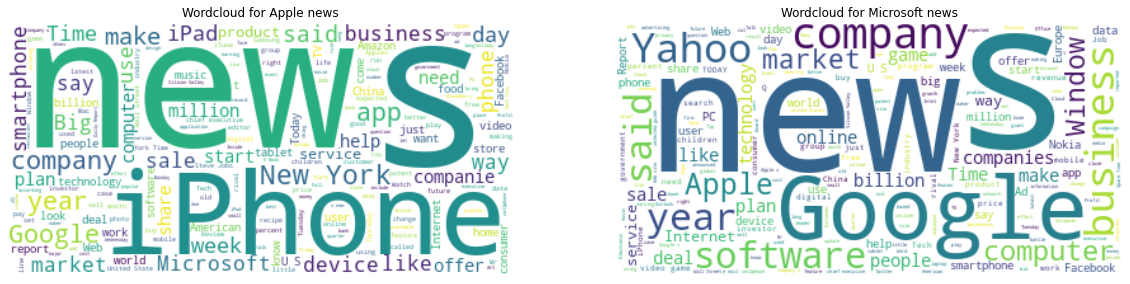

In [863]:
apples=WordCloud(stopwords=ENGLISH_STOP_WORDS.union(['Apple']), background_color='white').generate(apple_news)
micros=WordCloud(stopwords=ENGLISH_STOP_WORDS.union(['Microsoft']), background_color='white').generate(micro_news)

fig,ax=plt.subplots(ncols=2,figsize=(20,10))
ax[0].set_title('Wordcloud for Apple news')
ax[0].imshow(apples,interpolation='bilinear')
ax[0].axis('off')

ax[1].set_title('Wordcloud for Microsoft news')
ax[1].imshow(micros,interpolation='bilinear')
ax[1].axis('off')

plt.show()

# Data preparation

In [864]:
apple['Bullish']=(apple.Close>apple.Open).astype('category')
micro['Bullish']=(micro.Close>micro.Open).astype('category')


In [865]:
apple.drop(['Date','Open','High','Low','Close','Adj Close','Volume'],axis=1,inplace=True)
micro.drop(['Date','Open','High','Low','Close','Adj Close','Volume'],axis=1,inplace=True)

In [866]:
apple.Bullish=apple.Bullish.astype('int')
micro.Bullish=micro.Bullish.astype('int')

In [867]:
p=PorterStemmer()
for i in range(len(micro.News)):
    for word in word_tokenize(micro.News.iloc[i]):
        sentence=sentence+" "+p.stem(word)
    micro.News.iloc[i]=sentence
    sentence=''

c:\Users\ADMIN\Documents\Codebase\envs\machine_L\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Feature extraction

In [868]:
cnt1=CountVectorizer(lowercase=True, stop_words=ENGLISH_STOP_WORDS.union('s'),token_pattern=r"\w+", ngram_range=(1,5),max_features=200, min_df=2)
cnt2=CountVectorizer(lowercase=True, stop_words=ENGLISH_STOP_WORDS.union('s'),token_pattern=r'[^.,:; \d]+\w+', ngram_range=(1,5),max_features=300)

In [869]:
apple_x=apple.News
apple_y=apple.Bullish
msft_x=micro.News
msft_y=micro.Bullish

# Model building

In [870]:
apple_X_train,apple_X_test, apple_y_train, apple_y_test=train_test_split(apple_x,apple_y, test_size=0.2, stratify=apple_y, random_state=12345)
msft_X_train,msft_X_test, msft_y_train, msft_y_test=train_test_split(msft_x,msft_y, test_size=0.2, stratify=msft_y, random_state=12345)

In [871]:
apple_X_train=cnt1.fit_transform(apple_X_train).A
msft_X_train=cnt2.fit_transform(msft_X_train).A
apple_X_test=cnt1.transform(apple_X_test).A
msft_X_test=cnt2.transform(msft_X_test).A

In [872]:
apple_X_train = pd.DataFrame(apple_X_train,columns=cnt1.get_feature_names())
msft_X_train = pd.DataFrame(msft_X_train,columns=cnt2.get_feature_names())
apple_X_test = pd.DataFrame(apple_X_test,columns=cnt1.get_feature_names())
msft_X_test = pd.DataFrame(msft_X_test,columns=cnt2.get_feature_names())

In [873]:
def scorer(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    predictions=model.predict(X_test)
    acc = accuracy_score(y_test,predictions)
    prec= precision_score(y_test,predictions)
    rec=recall_score(y_test,predictions)
    f1=f1_score(y_test,predictions)
    return acc,prec,rec,f1

## Apple

In [875]:
LR=LogisticRegression(solver='liblinear')
KNNC=KNeighborsClassifier(n_neighbors=2)
SV=SVC(kernel='poly')
DTC=DecisionTreeClassifier(max_depth=8, class_weight={0:2,1:1.45}, max_features="sqrt",random_state=1234)
RF=RandomForestClassifier(class_weight={0:2,1:1.45},n_estimators=50, random_state=123456)
GBM=GradientBoostingClassifier(learning_rate= 0.4, max_depth= 2, max_features='auto', n_estimators= 150, random_state=12345)
ADA=AdaBoostClassifier()
XGBC=xgb.XGBClassifier(n_estimators=250,max_depth=2,eta=0.1)

In [876]:

scr=[]
for i in np.arange(0.1,10,0.1):
    scr.append([scorer(BernoulliNB(alpha=i),apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
#Finding the best alpha value for Bernoulli NB
pos=np.array(scr).mean(axis=2).argmax()

alp=0.1+0.1*pos

B=BernoulliNB(alpha=alp)

In [877]:

scr=[]
for i in np.arange(0.1,10,0.1):
    scr.append([scorer(GaussianNB(var_smoothing=i),apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
#Finding the best alpha value for Bernoulli NB
pos=np.array(scr).mean(axis=2).argmax()

alp=0.1+0.1*pos

G=GaussianNB(var_smoothing=alp)

In [878]:
# Testpad for setting the hyper parameters
'''
from sklearn.model_selection import GridSearchCV
gg=GridSearchCV(GradientBoostingClassifier(),param_grid={"learning_rate":np.arange(0.1,0.5,0.1), "n_estimators":np.arange(50,250,50),"max_depth":np.arange(2,6,2),"max_features":["auto", "sqrt", "log2"]}, scoring='precision',cv=5)
gg.fit(apple_X_train,apple_y_train)
gg.best_params_
'''

'\nfrom sklearn.model_selection import GridSearchCV\ngg=GridSearchCV(GradientBoostingClassifier(),param_grid={"learning_rate":np.arange(0.1,0.5,0.1), "n_estimators":np.arange(50,250,50),"max_depth":np.arange(2,6,2),"max_features":["auto", "sqrt", "log2"]}, scoring=\'precision\',cv=5)\ngg.fit(apple_X_train,apple_y_train)\ngg.best_params_\n'

In [879]:
logistic=pd.Series([*scorer(LR,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
knn=pd.Series([*scorer(KNNC,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
svm=pd.Series([*scorer(SV,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
nb=pd.Series([*scorer(B,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
gnb=pd.Series([*scorer(G,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
tree=pd.Series([*scorer(DTC,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
rf=pd.Series([*scorer(RF,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
ada=pd.Series([*scorer(ADA,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
gbm=pd.Series([*scorer(GBM,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
xgbc=pd.Series([*scorer(XGBC,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])

c:\Users\ADMIN\Documents\Codebase\envs\machine_L\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[22:51:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [880]:
scores=pd.DataFrame({"Logistic":logistic,'KNN':knn,'SVM':svm,'BernoulliNB':nb,"GaussianNB":gnb,"DecisionTree":tree,"Random Forest":rf,"Adaboost":ada,"GBM":gbm,"XGB":xgbc})
scores.index=['Accuracy','Precision','Recall','F1 score']
scores.transpose().sort_values(['F1 score','Precision'], ascending=False)

,Accuracy,Precision,Recall,F1 score
GaussianNB,0.883871,0.888646,0.992683,0.937788
Random Forest,0.877419,0.881210,0.995122,0.934708
SVM,0.873118,0.887417,0.980488,0.931634
GBM,0.875269,0.909302,0.953659,0.930952
XGB,0.868817,0.888641,0.973171,0.928987
DecisionTree,0.851613,0.891954,0.946341,0.918343
Adaboost,0.851613,0.895592,0.941463,0.917955
BernoulliNB,0.855914,0.927681,0.907317,0.917386
Logistic,0.843011,0.896471,0.929268,0.912575
KNN,0.763441,0.926136,0.795122,0.855643


# We'll use GBM based on the above table

In [881]:
confusion_matrix(apple_y_test,GBM.predict(apple_X_test))

array([[ 16,  39],
       [ 19, 391]], dtype=int64)

## Microsoft

c:\Users\ADMIN\Documents\Codebase\envs\machine_L\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Bullish', ylabel='count'>

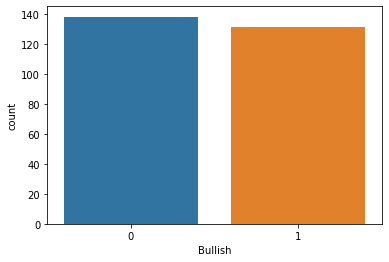

In [882]:
sns.countplot(msft_y_test)